# Import relevant libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SelectKBest
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics

# xgboost
from xgboost import XGBClassifier

# PCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from kneed import KneeLocator

# logreg / rfe
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# to display all rows in dataframes
pd.set_option('display.max_rows', None) 

# Load data

In [4]:
df = pd.read_csv("../data/grouped_data.csv")
X_train = pd.read_csv("../data/X_train_final.csv")
X_test = pd.read_csv("../data/X_test_final.csv")
X_train_full = pd.read_csv("../data/X_train_full.csv")
y_train = pd.read_csv("../data/y_train_final.csv")
y_test = pd.read_csv("../data/y_test_final.csv")
y_train_full = pd.read_csv("../data/y_train_full.csv")

In [14]:
len(set(X_train.columns.tolist()).intersection(set(X_train_full.columns.tolist())))

71

In [19]:
df.shape

(121838, 75)

In [7]:
X_train.shape

(109333, 71)

In [8]:
X_train_full.head()

,order_1,order_2,order_3,order_6,order_7,transcript_position,dwelling_time_1_min,dwelling_time_1_max,dwelling_time_1_median,dwelling_time_1_std,...,diff_mean_current_1_std,diff_mean_current_2_min,diff_mean_current_2_max,diff_mean_current_2_median,diff_mean_current_2_std,relative_position,count_A,count_C,count_G,count_T
0,A,A,A,A,C,0.085972,0.080194,0.270303,0.577465,0.409226,...,0.159519,0.822960,0.508126,0.840951,0.162353,0.857719,0.8,0.333333,0.0,0.0
1,T,T,A,T,T,0.093288,0.080194,0.072970,0.111335,0.096002,...,0.163467,0.871369,0.574215,0.862888,0.153319,0.298925,0.2,0.000000,0.0,1.0
2,G,T,G,C,T,0.049020,0.000000,0.121207,0.210597,0.179930,...,0.313132,0.358230,0.287107,0.290676,0.296405,0.638519,0.0,0.333333,0.5,0.5
3,A,A,G,A,G,0.013190,0.000000,0.216804,0.177733,0.197040,...,0.240405,0.188105,0.163597,0.144424,0.229216,0.104110,0.6,0.000000,0.5,0.0
4,A,T,A,C,T,0.059273,0.104496,0.270303,0.394366,0.303766,...,0.078990,0.890733,0.542795,0.864717,0.093901,0.636296,0.4,0.333333,0.0,0.5


In [9]:
X_train_full.shape

(135755, 71)

In [15]:
# one hot encode the categories
features_nominal = ['order_1', 'order_2', 'order_3', 'order_6', 'order_7']
X_train = pd.get_dummies(X_train, columns = features_nominal)
X_test = pd.get_dummies(X_test, columns = features_nominal)
X_train_full = pd.get_dummies(X_train_full, columns = features_nominal)

In [28]:
# https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
def remove_collinear_features(df_model, target_var, threshold, verbose):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold and which have the least correlation with the target (dependent) variable. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        df_model: features dataframe
        target_var: target (dependent) variable
        threshold: features with correlations greater than this value are removed
        verbose: set to "True" for the log printing

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = df_model.drop(target_var, 1).corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    dropped_feature = ""

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1): 
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                if verbose:
                    print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                col_value_corr = df_model[col.values[0]].corr(df_model[target_var])
                row_value_corr = df_model[row.values[0]].corr(df_model[target_var])
                if verbose:
                    print("{}: {}".format(col.values[0], np.round(col_value_corr, 3)))
                    print("{}: {}".format(row.values[0], np.round(row_value_corr, 3)))
                if col_value_corr < row_value_corr:
                    drop_cols.append(col.values[0])
                    dropped_feature = "dropped: " + col.values[0]
                else:
                    drop_cols.append(row.values[0])
                    dropped_feature = "dropped: " + row.values[0]
                if verbose:
                    print(dropped_feature)
                    print("-----------------------------------------------------------------------------")

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    df_model = df_model.drop(columns=drops)

    print("dropped columns: ")
    print(list(drops))
    print("-----------------------------------------------------------------------------")
    print("used columns: ")
    print(df_model.columns.tolist())

    #return df_model

In [20]:
# get full cleaned dataset to run
df_full = pd.concat([X_train_full, y_train_full], axis=1)

In [29]:
remove_collinear_features(df_full, 'label', 0.7, True)

dwelling_time_1_std | dwelling_time_1_max | 0.81
dwelling_time_1_std: 0.062
dwelling_time_1_max: 0.047
dropped: dwelling_time_1_max
-----------------------------------------------------------------------------
sd_current_1_std | sd_current_1_max | 0.82
sd_current_1_std: 0.09
sd_current_1_max: 0.037
dropped: sd_current_1_max
-----------------------------------------------------------------------------
mean_current_1_max | mean_current_1_min | 0.8
mean_current_1_max: 0.249
mean_current_1_min: 0.286
dropped: mean_current_1_max
-----------------------------------------------------------------------------
mean_current_1_median | mean_current_1_min | 0.9
mean_current_1_median: 0.259
mean_current_1_min: 0.286
dropped: mean_current_1_median
-----------------------------------------------------------------------------
mean_current_1_median | mean_current_1_max | 0.94
mean_current_1_median: 0.259
mean_current_1_max: 0.249
dropped: mean_current_1_max
----------------------------------------------

diff_sd_current_2_max: 0.098
sd_current_3_max: 0.07
dropped: sd_current_3_max
-----------------------------------------------------------------------------
diff_sd_current_2_max | sd_current_3_std | 0.74
diff_sd_current_2_max: 0.098
sd_current_3_std: 0.08
dropped: sd_current_3_std
-----------------------------------------------------------------------------
diff_sd_current_2_median | sd_current_2_median | 0.92
diff_sd_current_2_median: 0.056
sd_current_2_median: -0.053
dropped: sd_current_2_median
-----------------------------------------------------------------------------
diff_sd_current_2_std | sd_current_2_max | 0.72
diff_sd_current_2_std: 0.153
sd_current_2_max: 0.1
dropped: sd_current_2_max
-----------------------------------------------------------------------------
diff_sd_current_2_std | sd_current_2_std | 0.89
diff_sd_current_2_std: 0.153
sd_current_2_std: 0.179
dropped: diff_sd_current_2_std
-----------------------------------------------------------------------------
diff_s

order_3_G | sd_current_2_median | 0.73
order_3_G: 0.219
sd_current_2_median: -0.053
dropped: sd_current_2_median
-----------------------------------------------------------------------------
order_3_G | mean_current_2_min | 0.86
order_3_G: 0.219
mean_current_2_min: 0.172
dropped: mean_current_2_min
-----------------------------------------------------------------------------
order_3_G | mean_current_2_max | 0.92
order_3_G: 0.219
mean_current_2_max: 0.218
dropped: mean_current_2_max
-----------------------------------------------------------------------------
order_3_G | mean_current_2_median | 0.92
order_3_G: 0.219
mean_current_2_median: 0.168
dropped: mean_current_2_median
-----------------------------------------------------------------------------
order_3_G | diff_sd_current_2_std | 0.76
order_3_G: 0.219
diff_sd_current_2_std: 0.153
dropped: diff_sd_current_2_std
-----------------------------------------------------------------------------
order_3_G | diff_mean_current_2_min | 0.93


In [26]:
len(['transcript_position', 'dwelling_time_1_min', 'dwelling_time_1_median', 'sd_current_1_min', 'sd_current_1_median', 'mean_current_1_min', 'dwelling_time_2_min', 'sd_current_2_min', 'sd_current_2_std', 'mean_current_2_std', 'dwelling_time_3_min', 'dwelling_time_3_median', 'dwelling_time_3_std', 'sd_current_3_min', 'sd_current_3_median', 'mean_current_3_max', 'mean_current_3_std', 'diff_dwelling_time_1_median', 'diff_dwelling_time_1_std', 'diff_dwelling_time_2_median', 'diff_dwelling_time_2_std', 'diff_sd_current_2_max', 'diff_sd_current_2_median', 'diff_mean_current_1_std', 'relative_position', 'count_A', 'count_C', 'count_G', 'count_T', 'order_1_A', 'order_1_C', 'order_1_G', 'order_1_T', 'order_2_A', 'order_2_G', 'order_3_G', 'order_6_A', 'order_6_C', 'order_6_T', 'order_7_A', 'order_7_C', 'order_7_G', 'order_7_T', 'label'])

44

### Set train data to reduced features

In [144]:
X_train = X_train.drop(columns = ['diff_sd_current_1_std', 'mean_current_1_std', 'dwelling_time_3_max', 'dwelling_time_2_median', 'diff_mean_current_1_median', 'mean_current_1_median', 'dwelling_time_2_max', 'diff_mean_current_2_median', 'sd_current_2_max', 'diff_sd_current_2_min', 'sd_current_3_std', 'diff_dwelling_time_2_min', 'sd_current_2_median', 'diff_sd_current_1_max', 'order_3_A', 'mean_current_1_max', 'diff_sd_current_1_min', 'sd_current_1_max', 'dwelling_time_1_max', 'diff_mean_current_2_min', 'mean_current_2_median', 'order_2_T', 'mean_current_3_min', 'sd_current_1_std', 'dwelling_time_1_std', 'diff_dwelling_time_1_max', 'diff_mean_current_2_std', 'diff_mean_current_1_max', 'mean_current_2_max', 'sd_current_3_max', 'diff_sd_current_2_std', 'mean_current_3_median', 'dwelling_time_2_std', 'diff_dwelling_time_1_min', 'diff_sd_current_1_median', 'diff_dwelling_time_2_max', 'diff_mean_current_1_min', 'diff_mean_current_2_max', 'mean_current_2_min'])
X_test = X_test.drop(columns = ['diff_sd_current_1_std', 'mean_current_1_std', 'dwelling_time_3_max', 'dwelling_time_2_median', 'diff_mean_current_1_median', 'mean_current_1_median', 'dwelling_time_2_max', 'diff_mean_current_2_median', 'sd_current_2_max', 'diff_sd_current_2_min', 'sd_current_3_std', 'diff_dwelling_time_2_min', 'sd_current_2_median', 'diff_sd_current_1_max', 'order_3_A', 'mean_current_1_max', 'diff_sd_current_1_min', 'sd_current_1_max', 'dwelling_time_1_max', 'diff_mean_current_2_min', 'mean_current_2_median', 'order_2_T', 'mean_current_3_min', 'sd_current_1_std', 'dwelling_time_1_std', 'diff_dwelling_time_1_max', 'diff_mean_current_2_std', 'diff_mean_current_1_max', 'mean_current_2_max', 'sd_current_3_max', 'diff_sd_current_2_std', 'mean_current_3_median', 'dwelling_time_2_std', 'diff_dwelling_time_1_min', 'diff_sd_current_1_median', 'diff_dwelling_time_2_max', 'diff_mean_current_1_min', 'diff_mean_current_2_max', 'mean_current_2_min'])

In [48]:
X_train.columns

Index(['transcript_position', 'dwelling_time_1_min', 'dwelling_time_1_median',
       'sd_current_1_min', 'sd_current_1_median', 'mean_current_1_min',
       'dwelling_time_2_min', 'sd_current_2_min', 'sd_current_2_std',
       'mean_current_2_std', 'dwelling_time_3_min', 'dwelling_time_3_median',
       'dwelling_time_3_std', 'sd_current_3_min', 'sd_current_3_median',
       'mean_current_3_max', 'mean_current_3_std',
       'diff_dwelling_time_1_median', 'diff_dwelling_time_1_std',
       'diff_dwelling_time_2_median', 'diff_dwelling_time_2_std',
       'diff_sd_current_2_max', 'diff_sd_current_2_median',
       'diff_mean_current_1_std', 'relative_position', 'count_A', 'count_C',
       'count_G', 'count_T', 'order_1_A', 'order_1_C', 'order_1_G',
       'order_1_T', 'order_2_A', 'order_2_G', 'order_3_G', 'order_6_A',
       'order_6_C', 'order_6_T', 'order_7_A', 'order_7_C', 'order_7_G',
       'order_7_T'],
      dtype='object')

# Feature Selection

## SelectKBest to determine number of variables to keep

In [31]:
def feature_selection(variable_counts, score_function):
    selection_model = SelectKBest(score_func = score_function, k = variable_counts) #create selection model based on score function
    selection = selection_model.fit(X_train, y_train) #fit the selection to the data
    features_selected = X_train.columns[selection.get_support()] #transform the training data based on selected features
    X_train_selected = selection_model.fit_transform(X_train, y_train)
    
    #calculate accuracy of prediction based on selected features
    reg = LogisticRegression()
    reg.fit(X_train_selected, y_train)
    y_pred = reg.predict(X_test[features_selected])
    
    return metrics.accuracy_score(y_test, y_pred)

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array w

C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: T

C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\

C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validati

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validati

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validati

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validati

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validati

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

     features count  accuracy      score function
0               1.0     0.672          chi square
1               2.0     0.881          chi square
2               3.0     0.881          chi square
3               4.0     0.731          chi square
4               5.0     0.800          chi square
5               6.0     0.800          chi square
6               7.0     0.812          chi square
7               8.0     0.776          chi square
8               9.0     0.776          chi square
9              10.0     0.766          chi square
10             11.0     0.766          chi square
11             12.0     0.766          chi square
12             13.0     0.764          chi square
13             14.0     0.764          chi square
14             15.0     0.764          chi square
15             16.0     0.782          chi square
16             17.0     0.799          chi square
17             18.0     0.770          chi square
18             19.0     0.770          chi square


<AxesSubplot:xlabel='features count', ylabel='accuracy'>

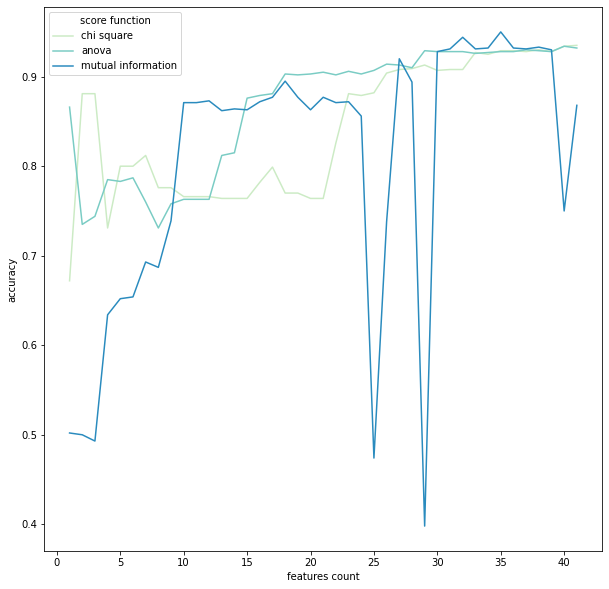

In [33]:
accuracy_df = pd.DataFrame({"features count": [], "accuracy": [], "score function": []})
function_list = [chi2, f_classif, mutual_info_classif]
function_name = ["chi square", "anova", "mutual information"]

for j in range(len(function_list)):
    func = function_list[j]
    func_name = function_name[j]
    for i in range(1, len(X_train.columns)-1):
        accuracy = feature_selection(i, func)
        new_record = {"features count": round(i), "accuracy": round(accuracy, 3), "score function": func_name}
        accuracy_df = accuracy_df.append(new_record, ignore_index = True)
        
print(accuracy_df)
plt.figure(figsize = (10,10))
sns.lineplot(data = accuracy_df, x = 'features count', y = 'accuracy', hue = 'score function', palette = 'GnBu')

                       features       scores
34                    order_2_G  7512.499860
38                    order_6_T  6354.981842
33                    order_2_A  3394.407173
39                    order_7_A  3195.894694
36                    order_6_A  2724.765668
37                    order_6_C  2484.836649
27                      count_G  2145.706256
35                    order_3_G  1931.441745
25                      count_A  1919.877705
41                    order_7_G  1636.684336
30                    order_1_C   607.174093
5            mean_current_1_min   538.503724
26                      count_C   358.633997
40                    order_7_C   300.233053
32                    order_1_T   258.990965
24            relative_position   243.946235
7              sd_current_2_min   241.148498
9            mean_current_2_std   222.585824
28                      count_T   169.552119
4           sd_current_1_median   158.056137
42                    order_7_T    86.764757
8         

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                       features        scores
27                      count_G  17895.555126
34                    order_2_G  16848.359878
25                      count_A  13325.848318
38                    order_6_T  12923.797644
5            mean_current_1_min  10323.223463
33                    order_2_A   5099.989105
35                    order_3_G   5079.589659
9            mean_current_2_std   4863.141142
7              sd_current_2_min   4529.154441
39                    order_7_A   4151.240652
36                    order_6_A   4080.547895
37                    order_6_C   3381.703159
8              sd_current_2_std   3302.220688
41                    order_7_G   2366.268473
16           mean_current_3_std   2263.654728
24            relative_position   1460.915977
26                      count_C   1280.017060
15           mean_current_3_max   1242.812120
4           sd_current_1_median   1209.170164
21        diff_sd_current_2_max   1084.114527
28                      count_T   

C:\Users\C\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                       features    scores
8              sd_current_2_std  0.508742
18     diff_dwelling_time_1_std  0.505432
20     diff_dwelling_time_2_std  0.504703
16           mean_current_3_std  0.504327
12          dwelling_time_3_std  0.503787
23      diff_mean_current_1_std  0.501405
9            mean_current_2_std  0.500636
24            relative_position  0.467885
0           transcript_position  0.160200
22     diff_sd_current_2_median  0.081033
27                      count_G  0.080511
5            mean_current_1_min  0.075850
21        diff_sd_current_2_max  0.074960
4           sd_current_1_median  0.073430
17  diff_dwelling_time_1_median  0.073395
34                    order_2_G  0.069454
19  diff_dwelling_time_2_median  0.065836
25                      count_A  0.062643
38                    order_6_T  0.057097
7              sd_current_2_min  0.053714
2        dwelling_time_1_median  0.047945
11       dwelling_time_3_median  0.041044
3              sd_current_1_min  0

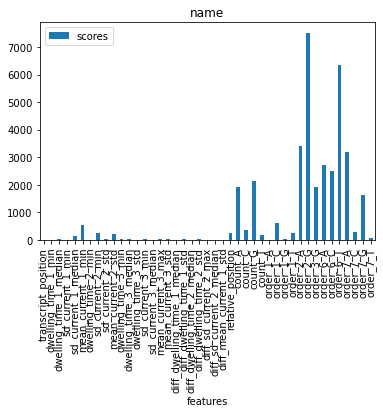

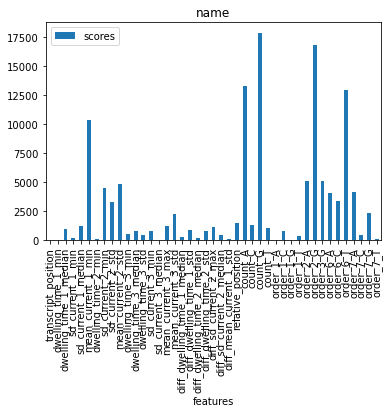

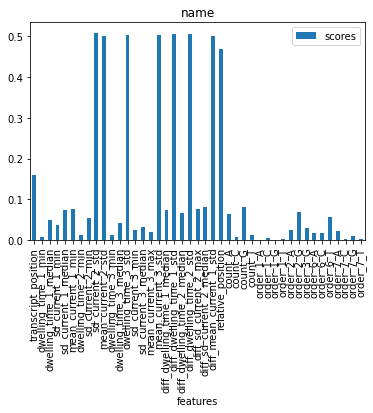

In [34]:
for i in range(len(function_list)):
    function = function_list[i]
    name = function_name[i]
    selection_model = SelectKBest(score_func = function, k=8).fit(X_train, y_train)
    feature_score = pd.DataFrame({'features': X_train.columns.values, "scores": selection_model.scores_})
    print(feature_score.sort_values(by = ['scores'], ascending = False))
    print(feature_score.plot(x = "features", kind = "bar", title = "name"))

### List of important features

In [35]:
impt_feat = []

## XGB feature importance

In [36]:
# fit model to training data
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, xgb.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame(feats.items(), columns=['Feature', 'Importance'])
#.rename(columns={0: 'importance'})
importances = importances.sort_values(by = ['Importance'], ascending = False)
impt_feat.extend(importances.Feature.iloc[0:30].tolist())

C:\Users\C\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\C\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\C\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[15:07:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [7]:
impt_feat

['order_2_G',
 'count_G',
 'order_6_T',
 'order_7_A',
 'mean_current_2_median',
 'sd_current_2_median',
 'mean_current_2_std',
 'mean_current_3_std',
 'sd_current_2_min',
 'diff_mean_current_2_median',
 'order_7_G',
 'order_6_A',
 'mean_current_3_median',
 'order_7_T',
 'sd_current_2_std',
 'diff_mean_current_2_max',
 'mean_current_2_min',
 'diff_mean_current_1_min',
 'diff_mean_current_1_median',
 'mean_current_2_max',
 'mean_current_3_min',
 'mean_current_1_median',
 'order_2_A',
 'relative_position',
 'sd_current_3_median',
 'mean_current_1_max',
 'order_7_C',
 'mean_current_1_std',
 'count_T',
 'order_1_T']

## PCA dimensionality reduction

Remove categorical features

In [49]:
X_train_full.columns

Index(['transcript_position', 'dwelling_time_1_min', 'dwelling_time_1_max',
       'dwelling_time_1_median', 'dwelling_time_1_std', 'sd_current_1_min',
       'sd_current_1_max', 'sd_current_1_median', 'sd_current_1_std',
       'mean_current_1_min', 'mean_current_1_max', 'mean_current_1_median',
       'mean_current_1_std', 'dwelling_time_2_min', 'dwelling_time_2_max',
       'dwelling_time_2_median', 'dwelling_time_2_std', 'sd_current_2_min',
       'sd_current_2_max', 'sd_current_2_median', 'sd_current_2_std',
       'mean_current_2_min', 'mean_current_2_max', 'mean_current_2_median',
       'mean_current_2_std', 'dwelling_time_3_min', 'dwelling_time_3_max',
       'dwelling_time_3_median', 'dwelling_time_3_std', 'sd_current_3_min',
       'sd_current_3_max', 'sd_current_3_median', 'sd_current_3_std',
       'mean_current_3_min', 'mean_current_3_max', 'mean_current_3_median',
       'mean_current_3_std', 'diff_dwelling_time_1_min',
       'diff_dwelling_time_1_max', 'diff_dwelling_t

In [50]:
df_pca = X_train_full.drop(columns = ['order_1_A', 'order_1_C', 'order_1_G',
       'order_1_T', 'order_2_A', 'order_2_G', 'order_2_T', 'order_3_A',
       'order_3_G', 'order_6_A', 'order_6_C', 'order_6_T', 'order_7_A',
       'order_7_C', 'order_7_G', 'order_7_T'])

In [52]:
_ , p_value = calculate_bartlett_sphericity(df_pca)
p_value

0.0

In [53]:
_, kmo_score = calculate_kmo(df_pca)
kmo_score 

C:\Users\C\anaconda3\lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.828965835544907

As p-value < 0.5 and kmo score > 0.5, PCA is suitable on the dataframe.

In [54]:
fa = FactorAnalyzer(n_factors = 10, method = 'principal', rotation='varimax')
fa.fit(df_pca)
eigenvalues, _ = fa.get_eigenvalues()
variances = fa.get_factor_variance()

Text(0, 0.5, 'Proportion of Variance Explained by PC')

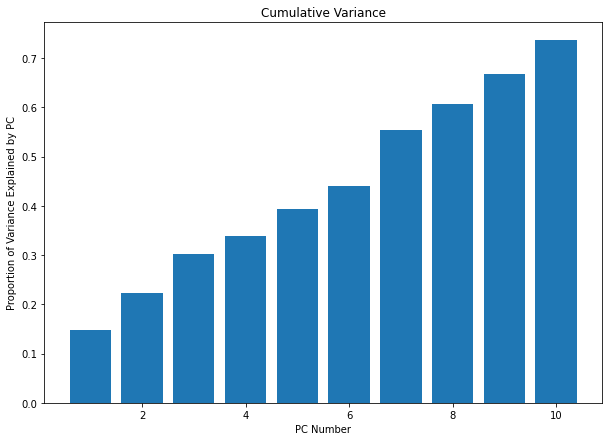

In [55]:
x = list(range(1,11))
plt.figure(figsize=(10, 7)) 
plt.bar(x,variances[2])
plt.title('Cumulative Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')

In [56]:
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x):
        if x <= -0.7 or x >= 0.7:
            return x
        else:
            return("")    
    # REMARK: we use 'principal' method and 'varimax' rotation in the FactorAnalyzer function.
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax')
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    return loadings

# The following function generates the rotation matrix. Recall that we use
# this matrix to determine if the PCs generated are easily understandable and appropriate.
# The argument "num_of_pcs" specifies, the number of PCs we wish to generate.

In [57]:
def variance_explained(num_of_pcs,data):
    # REMARK: we use 'principal' method and 'varimax' rotation in the FactorAnalyzer function.
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax')
    f.fit(data)
    return f.get_factor_variance()[2][num_of_pcs-1]

# The following function calculates the variance explained by the specified desired number of PCs.

Chose 9 PCs as it explains >70% of the variance

In [58]:
variance_explained(10, df_pca)

0.7358976242101793

In [61]:
PCA_df = evaluate_pcs(10,df_pca)

In [128]:
value = []
which = lambda lst:list(np.where(lst)[0])
for i in PCA_df.columns:
    value.extend(which(PCA_df[i] == ''))
    
value = pd.DataFrame(value).rename(columns = {0: 'rowno'})
val_counts = pd.DataFrame(value.value_counts()).reset_index()

Drop the columns that are not in any PCs as they are not as important.

In [133]:
keep_cols = val_counts[val_counts[0] != 10]['rowno']

In [136]:
PCA_df.index[keep_cols]

Index(['mean_current_2_median', 'sd_current_1_std', 'diff_sd_current_2_min',
       'diff_sd_current_2_max', 'diff_sd_current_2_median',
       'mean_current_1_max', 'mean_current_1_min', 'sd_current_1_max',
       'sd_current_1_median', 'diff_mean_current_2_min',
       'diff_mean_current_2_max', 'diff_mean_current_2_median',
       'diff_mean_current_2_std', 'dwelling_time_1_std',
       'dwelling_time_1_median', 'dwelling_time_1_max',
       'mean_current_1_median', 'diff_sd_current_1_min',
       'diff_sd_current_1_max', 'mean_current_2_max', 'dwelling_time_3_max',
       'mean_current_2_min', 'dwelling_time_3_std', 'sd_current_2_std',
       'sd_current_3_median', 'sd_current_3_std', 'sd_current_2_max',
       'mean_current_3_max', 'mean_current_3_median',
       'diff_dwelling_time_1_min', 'diff_dwelling_time_1_max',
       'dwelling_time_2_std', 'diff_dwelling_time_2_min',
       'diff_dwelling_time_2_max', 'dwelling_time_2_max',
       'mean_current_3_min'],
      dtype='object

In [137]:
impt_feat.extend(PCA_df.index[keep_cols])

## RFE Recursive Feature Elimination

In [138]:
logreg = LogisticRegression(max_iter=1000)

In [139]:
rfe3 = RFE(logreg, n_features_to_select=30)
rfe3 = rfe3.fit(X_train, y_train.values.ravel())

In [140]:
# cols remaining
cols_keep = X_train.columns.values[rfe3.support_]
impt_feat.extend(cols_keep)

## Feature Importance using Random Forest

In [141]:
# baseline model with default parameters
import time
start = time.time()
forest1 = RandomForestClassifier(random_state = 1, n_jobs= -1)
forest1.fit(X_train,y_train.values.ravel())
end = time.time()
print("Time taken:", (end-start)/60, "minutes")

Time taken: 0.1850706179936727 minutes


In [145]:
rf_y_pred = forest1.predict(X_test)
y_predict_prob = forest1.predict_proba(X_test)[:, 1]

In [146]:
print(metrics.confusion_matrix(y_test, rf_y_pred))
# TN FP
# FN TP

print(f'accuracy:  {metrics.accuracy_score(y_test, rf_y_pred)}')
print(f'precision: {metrics.precision_score(y_test,rf_y_pred)}')
print(f'recall:    {metrics.recall_score(y_test, rf_y_pred)}')
print(f'roc auc:   {metrics.roc_auc_score(y_test, y_predict_prob)}')
print(f'pr auc:    {metrics.average_precision_score(y_test, y_predict_prob)}')

[[22635    13]
 [ 1157    27]]
accuracy:  0.9509063444108762
precision: 0.675
recall:    0.022804054054054054
roc auc:   0.8624918852091229
pr auc:    0.3380105559528198


In [147]:
importance = forest1.feature_importances_
importance

array([0.03191136, 0.01034191, 0.02105161, 0.03177072, 0.03607885,
       0.05169402, 0.0117335 , 0.04523388, 0.04909616, 0.05683675,
       0.01077121, 0.02073375, 0.02164791, 0.02352116, 0.03003304,
       0.03031029, 0.0513845 , 0.02579865, 0.02402842, 0.02350174,
       0.02205948, 0.02399065, 0.04832135, 0.02986915, 0.03084434,
       0.02086527, 0.00508988, 0.03100654, 0.01049444, 0.00332198,
       0.00169116, 0.00329546, 0.00248807, 0.00901035, 0.04735026,
       0.01095019, 0.00750637, 0.00923296, 0.05600463, 0.00778872,
       0.0030661 , 0.00464669, 0.00362653])

In [148]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, forest1.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame(feats.items(), columns=['Feature', 'Importance'])
#.rename(columns={0: 'importance'})
importances = importances.sort_values(by = ['Importance'], ascending = False)
importances

,Feature,Importance
9,mean_current_2_std,0.056837
38,order_6_T,0.056005
5,mean_current_1_min,0.051694
16,mean_current_3_std,0.051384
8,sd_current_2_std,0.049096
22,diff_sd_current_2_median,0.048321
34,order_2_G,0.047350
7,sd_current_2_min,0.045234
4,sd_current_1_median,0.036079
0,transcript_position,0.031911


In [149]:
importances.Feature.iloc[0: 30].tolist()

['mean_current_2_std',
 'order_6_T',
 'mean_current_1_min',
 'mean_current_3_std',
 'sd_current_2_std',
 'diff_sd_current_2_median',
 'order_2_G',
 'sd_current_2_min',
 'sd_current_1_median',
 'transcript_position',
 'sd_current_1_min',
 'count_G',
 'relative_position',
 'mean_current_3_max',
 'sd_current_3_median',
 'diff_mean_current_1_std',
 'diff_dwelling_time_1_median',
 'diff_dwelling_time_1_std',
 'diff_sd_current_2_max',
 'sd_current_3_min',
 'diff_dwelling_time_2_median',
 'diff_dwelling_time_2_std',
 'dwelling_time_3_std',
 'dwelling_time_1_median',
 'count_A',
 'dwelling_time_3_median',
 'dwelling_time_2_min',
 'order_3_G',
 'dwelling_time_3_min',
 'count_T']

In [150]:
impt_feat.extend(importances.Feature.iloc[0: 30].tolist())

# Check the Frequencies

In [151]:
features = pd.DataFrame(impt_feat)
features.value_counts()

diff_sd_current_2_median       4
sd_current_3_median            4
sd_current_2_std               4
sd_current_1_median            4
mean_current_1_min             4
mean_current_3_max             4
dwelling_time_1_median         3
diff_sd_current_2_max          3
mean_current_3_std             3
mean_current_2_std             3
order_2_G                      3
order_3_G                      3
transcript_position            3
order_6_T                      3
diff_mean_current_1_std        3
relative_position              3
sd_current_1_min               3
sd_current_2_min               3
dwelling_time_3_std            2
count_G                        2
order_6_C                      2
order_1_A                      2
dwelling_time_3_median         2
order_7_A                      2
order_7_T                      2
sd_current_3_min               2
dwelling_time_3_min            2
count_A                        2
diff_dwelling_time_1_std       2
dwelling_time_2_min            2
count_T   

We will thus select features where the value counts are >= 2

# Drop correlated features from v0.1 columns

In [161]:
v01_keep_cols = ['diff_mean_current_1_median', 'sd_current_2_median', 'mean_current_1_median', 'diff_mean_current_2_max', 'mean_current_3_median', 'mean_current_1_max', 'sd_current_2_std', 'order_6_T', 'mean_current_3_std', 'diff_sd_current_2_std', 'mean_current_3_min', 'sd_current_2_min', 'mean_current_2_std', 'mean_current_2_median', 'mean_current_1_std', 'sd_current_3_median', 'count_G', 'mean_current_1_min', 'diff_sd_current_1_std', 'diff_mean_current_2_std', 'sd_current_1_median', 'mean_current_3_max', 'mean_current_2_min', 'relative_position', 'mean_current_2_max', 'diff_mean_current_1_min', 'diff_sd_current_1_median', 'diff_sd_current_2_median', 'sd_current_2_max', 'dwelling_time_3_max', 'order_2_G', 'sd_current_3_max', 'sd_current_3_std', 'diff_mean_current_2_median']

In [171]:
# get full cleaned dataset to run
X_train_full1 = X_train_full[v01_keep_cols]
df_full1 = pd.concat([X_train_full1, y_train_full], axis=1)
remove_collinear_features(df_full1, 'label', 0.9, True)

mean_current_1_max | mean_current_1_median | 0.94
mean_current_1_max: 0.249
mean_current_1_median: 0.259
dropped: mean_current_1_max
-----------------------------------------------------------------------------
mean_current_2_median | diff_mean_current_2_max | 0.91
mean_current_2_median: 0.168
diff_mean_current_2_max: -0.122
dropped: diff_mean_current_2_max
-----------------------------------------------------------------------------
mean_current_2_min | diff_mean_current_2_max | 0.91
mean_current_2_min: 0.172
diff_mean_current_2_max: -0.122
dropped: diff_mean_current_2_max
-----------------------------------------------------------------------------
mean_current_2_min | mean_current_2_median | 0.94
mean_current_2_min: 0.172
mean_current_2_median: 0.168
dropped: mean_current_2_median
-----------------------------------------------------------------------------
mean_current_2_max | mean_current_2_median | 0.97
mean_current_2_max: 0.218
mean_current_2_median: 0.168
dropped: mean_current_

In [169]:
# threshold = 0.7
len(['sd_current_2_std', 'order_6_T', 'mean_current_3_std', 'sd_current_2_min', 'mean_current_2_std', 'mean_current_1_std', 'sd_current_3_median', 'count_G', 'mean_current_1_min', 'sd_current_1_median', 'mean_current_3_max', 'relative_position', 'mean_current_2_max', 'diff_mean_current_1_min', 'diff_sd_current_2_median', 'dwelling_time_3_max', 'order_2_G', 'label'])

18

In [170]:
# threshold = 0.8
len(['sd_current_2_std', 'order_6_T', 'mean_current_3_std', 'mean_current_3_min', 'sd_current_2_min', 'mean_current_2_std', 'mean_current_1_std', 'sd_current_3_median', 'count_G', 'mean_current_1_min', 'diff_sd_current_1_std', 'diff_mean_current_2_std', 'sd_current_1_median', 'mean_current_3_max', 'relative_position', 'mean_current_2_max', 'diff_mean_current_1_min', 'diff_sd_current_1_median', 'diff_sd_current_2_median', 'dwelling_time_3_max', 'order_2_G', 'sd_current_3_std', 'label'])

23

In [166]:
# threshold = 0.9
len(['mean_current_1_median', 'mean_current_3_median', 'sd_current_2_std', 'order_6_T', 'mean_current_3_std', 'diff_sd_current_2_std', 'mean_current_3_min', 'sd_current_2_min', 'mean_current_2_std', 'mean_current_1_std', 'sd_current_3_median', 'count_G', 'mean_current_1_min', 'diff_sd_current_1_std', 'diff_mean_current_2_std', 'sd_current_1_median', 'mean_current_3_max', 'relative_position', 'mean_current_2_max', 'diff_mean_current_1_min', 'diff_sd_current_1_median', 'diff_sd_current_2_median', 'sd_current_2_max', 'dwelling_time_3_max', 'order_2_G', 'sd_current_3_max', 'sd_current_3_std', 'label'])

28